# Twitter Sentiment Dataset

### Dalam submission ini saya akan klasifikasi sentiment warganet khususnya di twitter. Klasifikasi di bagi menjadi 3 kelas yaitu kicauan bernada positif, negatif dan netral. 
### Beberapa gambaran dari proses dan hasil dalam submission ini yaitu,
1. Dataset memiliki 33000 sampel.
2. Data memiliki 3 kelas.
3. Menggunakan LSTM dan Embedding dalam model.
4. Menggunakan model sequential.
5. Validation set sebesar 20% dari total dataset.
6. Fungsi tokenizer terimplementasi didalamnya.
7. Mengimplementasikan callback.
8. Membuat plot loss dan akurasi.
9. Mengimplementasikan teknik diluar modul.
10. Akurasi dari model mencapai 90%.

## 1. Import library yang dibutuhkan. Open data yang diambil dari https://www.kaggle.com/cosmos98/twitter-and-reddit-sentimental-analysis-dataset?select=Twitter_Data.csv .

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import time

df = pd.read_csv('drive/My Drive/Pengembangan-ML/Submission_NLP/dataset/Twitter_Data.csv')

## 2. Pengecekan apakah terdapat data yang bernilai NULL atau Missing Value.

In [2]:
df.isnull().sum()

clean_text    4
category      7
dtype: int64

## 3. Untuk data yang bernilai Missing Value akan di DROP.

In [3]:
df.dropna(inplace=True)
df.isnull().sum()

clean_text    0
category      0
dtype: int64

## 4. Rename nama kolom dan value.

In [4]:
df = df.rename(columns={'clean_text': 'selected_text', 'category': 'sentiment'})

Pada kolom sentiment memiliki 3 nilai unique yaitu -1, 0, 1. Secara berturut-turut adalah negatif, netral, positif.

In [5]:
df.sentiment.unique()

array([-1.,  0.,  1.])

Merubah nilai -1, 0, 1 agar lebih mudah dipahami.

In [6]:
df.sentiment[df['sentiment'] == 1] = 'positive' 
df.sentiment[df['sentiment'] == -1] = 'negative'
df.sentiment[df['sentiment'] == 0] = 'neutral'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [7]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162969 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   selected_text  162969 non-null  object
 1   sentiment      162969 non-null  object
dtypes: object(2)
memory usage: 3.7+ MB


,selected_text,sentiment
0,when modi promised “minimum government maximum...,negative
1,talk all the nonsense and continue all the dra...,neutral
2,what did just say vote for modi welcome bjp t...,positive
3,asking his supporters prefix chowkidar their n...,positive
4,answer who among these the most powerful world...,positive


## 5. Membuat DataFrame baru berdasarkan nilai sentiment-nya

In [8]:
df_positive = df[df['sentiment'] == 'positive']
df_neutral = df[df['sentiment'] == 'neutral']
df_negative = df[df['sentiment'] == 'negative']

## 6. Melihat jumlah masing-masing data setiap sentiment.

Total data yang ada : 162969


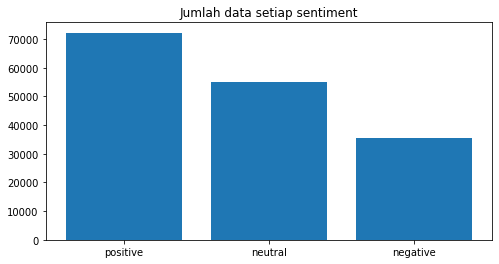

In [9]:
val_count = df.sentiment.value_counts()
plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Jumlah data setiap sentiment")
print('Total data yang ada :' ,df.shape[0])

Dari data diatas terlihat bahwa jumlah masing-masing sentiment berbeda lumayan jauh yang dapat menyebabkan overfitting. Oleh karena itu akan dilakukan pemilihan secara merata.

## 7. Parameter
Karena data berjumlah 162969. maka, akan di reduksi menjadi n data untuk masing-masing sentiment dengan pengambilan secara random.

In [10]:
n = 11000 # Jumlah sample yang akan di ambil sebagai bahan trainning
ln = 0.001 # Learning Rate
input_dim = 9000 # Input Dimensi Embedding
output_dim = 64  # Output
oov = 'x' 

# Parameter Fitting
epochs = 30
batch_size = 256

df = pd.concat([df_positive.sample(n), df_neutral.sample(n), df_negative.sample(n)]) # Pengambilan sample n data secara random

## 8. Setting label

Karena label kita berupa data kategorikal, maka kita perlu melakukan proses one-hot-encoding. Jalankan kode di bawah untuk melakukan one-hot-encoding dan membuat dataframe baru.

In [11]:
category = pd.get_dummies(df.sentiment)
df_baru = pd.concat([df, category], axis = 1)
df_baru = df_baru.drop(columns = ['sentiment'])
df_baru

,selected_text,negative,neutral,positive
134084,they telling lies despair win they want manipu...,0,0,1
152563,and the best runner award goes rahul gandhi ru...,0,0,1
99253,the response when asked contest the from rae b...,0,0,1
70829,payroll clown prince got offended when eminen...,0,0,1
8285,compare between rahul gandhi and modi intellec...,0,0,1
...,...,...,...,...
12180,ugly talk allowed cms their lok sabha camaigns...,1,0,0
142298,arabic killed journalist\nmodi dude killed who...,1,0,0
115074,the whole lutyens brigade sickular journalists...,1,0,0
53209,sir working modis fingers let just make sure t...,1,0,0


In [12]:
text = df_baru['selected_text'].values
label = df_baru[['negative', 'neutral', 'positive']].values

Split sebesar 20% sebagai data testing.

In [13]:
from sklearn.model_selection import train_test_split
text_latih, text_test, label_latih, label_test = train_test_split(text, label, test_size=0.2)

In [14]:
print(len(text))
print(len(text_latih))
print(len(text_test))

33000
26400
6600


## 9. Tokenisasi

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
 
tokenizer = Tokenizer(num_words=input_dim, oov_token=oov)
tokenizer.fit_on_texts(text_latih) 
tokenizer.fit_on_texts(text_test)
 
sequence_latih = tokenizer.texts_to_sequences(text_latih)
sequence_test = tokenizer.texts_to_sequences(text_test)
 
padded_latih = pad_sequences(sequence_latih) 
padded_test = pad_sequences(sequence_test)

## 10. Model

Terdapat beberapa layer yang akan digunakan dalam pembuatan model. Yaitu, Embedding, LSTM, Neuron. Selain itu juga diterapkan dropout dan beberapa parameter selain yang di modul. Yang mana berfungsi agar model tidak overfitting. Contohnya regularizer, trainable, dan menentukan nilai learning rate.

In [ ]:

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=input_dim, output_dim= output_dim, trainable=True),
    tf.keras.layers.LSTM(64, dropout=0.2),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.00001)),
    tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.00001)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation= 'softmax')
])
model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(learning_rate=ln),metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          576000    
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 51        
Total params: 611,683
Trainable params: 611,683
Non-trainable params: 0
__________________________________________________

## 11. Callback
Callback ini membantu stopping trainning jika akurasi validasi telah diatas 90%.Atau, jika terjadi overfitting ketika akurasi trainning diatas 96% tetapi akurasi validasi masih dibawah 90%.

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.96 or logs.get('val_accuracy')>0.90):
      if(logs.get('val_accuracy') > 0.90):
        print("\nAkurasi Validasi telah mencapai > 90%!")
        self.model.stop_training = True
      else:
        print("\nAkurasi Training > 95% tetapi Validasi < 90%!")
        self.model.stop_training = True
callbacks = myCallback()

## 12. Trainning dan Validation
Dalam trainning model klasifikasi hasil akurasi validasi sebesar 90 %.

In [ ]:
start = time.time()
hist = model.fit(padded_latih, label_latih, epochs = epochs, batch_size = batch_size, validation_data=(padded_test, label_test), verbose=2, callbacks=[callbacks])
finish = time.time() - start
durasi = time.strftime("%H:%M:%S", time.gmtime(finish))
print('Lama pelatihan %s menit' %(durasi))

Epoch 1/30
104/104 - 17s - loss: 1.0196 - accuracy: 0.4639 - val_loss: 0.8552 - val_accuracy: 0.5659
Epoch 2/30
104/104 - 16s - loss: 0.7094 - accuracy: 0.6233 - val_loss: 0.5923 - val_accuracy: 0.7414
Epoch 3/30
104/104 - 16s - loss: 0.4516 - accuracy: 0.8191 - val_loss: 0.3637 - val_accuracy: 0.8838
Epoch 4/30
104/104 - 16s - loss: 0.2871 - accuracy: 0.9086 - val_loss: 0.3620 - val_accuracy: 0.8889
Epoch 5/30
104/104 - 16s - loss: 0.2187 - accuracy: 0.9305 - val_loss: 0.3354 - val_accuracy: 0.8991
Epoch 6/30

Akurasi Validasi telah mencapai > 90%!
104/104 - 16s - loss: 0.1927 - accuracy: 0.9444 - val_loss: 0.3896 - val_accuracy: 0.9077
Lama pelatihan 00:01:40 menit


## 13. Plotting

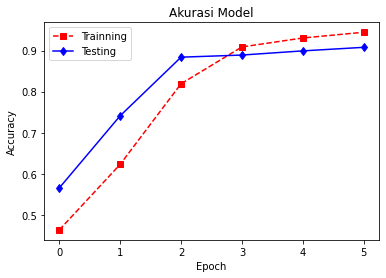

In [ ]:
plt.plot(hist.history['accuracy'], 'r--s',)
plt.plot(hist.history['val_accuracy'], 'b-d')
plt.title('Akurasi Model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Trainning', 'Testing'], loc='upper left')
plt.show()

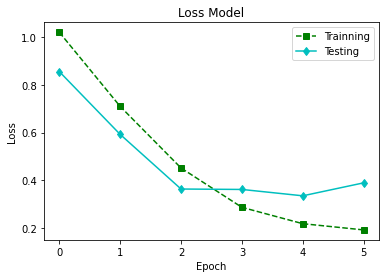

In [ ]:
plt.plot(hist.history['loss'], 'g--s')
plt.plot(hist.history['val_loss'], 'c-d')
plt.title('Loss Model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Trainning', 'Testing'], loc='upper right')
plt.show()

## Pada hasil trainning berhasil menghasilkan model yang dapat mengklasifikasi teks dengan akurasi testing diatas 90% dan loss kurang lebih 35%